# Web-Scraping, Dictionaries, Sentiment 

Sanjiv R. Das

**Note: We may need to use the PyTorch Kernel for this notebook**

**Reading references**

- NLTK: http://www.nltk.org/book/
- Introduction to Linguistics: http://www.ling.upenn.edu/courses/Fall_2003/ling001/
- My book on Text Analytics for Finance: http://srdas.github.io/Papers/Das_TextAnalyticsInFinance.pdf
- A history of Information Retrieval, [Harmon (2019)](https://www.nowpublishers.com/article/Details/INR-065); [pdf](https://drive.google.com/file/d/14OVI18rui61vdNOKQCfD7-8CM4wVmYTw/view?usp=sharing)

We will be using a mix of R and Python in this notebook.

In [1]:
%%capture
#INCLUDING SCIENTIFIC AND NUMERICAL COMPUTING LIBRARIES
#Run this code to make sure that you have all the libraries at one go.
%pylab inline
import os
!pip install ipypublish
from ipypublish import nb_setup
import pandas as pd
%load_ext rpy2.ipython

# Basic lines of code needed to import a data file with permissions from Google Drive
from google.colab import drive
# drive.mount("/content/drive", force_remount=True)
drive.mount('/content/drive')
os.chdir("drive/My Drive/Teaching/NLP/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g6hBdKucoNPJP5k7s1SYVcVT4cDcXogHxQQlDjb002LinPKeJdRV2c


In [ ]:
# # No need to run this, we will use another notebook with a R kernel
# !conda install -c r r -y
# !conda install -c r rpy2 -y
# %load_ext rpy2.ipython

In [ ]:
# Load if needed on Windows
# !curl -O "https://raw.githubusercontent.com/vitorcurtis/RWinOut/master/RWinOut.py"
# %load_ext RWinOut

## Information Extraction

This is often the first step in NLP work, i.e., extracting information from raw text. The simplest form of this is pattern matching. Here, we see how easy it is to do with SpaCy. 

In [2]:
# spaCy stuff
!pip install spacy
!python -m spacy download en_core_web_sm
!python -m spacy download en

import spacy 

nlp = spacy.load("en")

‚úî Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
‚úî Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
‚úî Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [3]:
import re 
import string 
import nltk 
from tqdm import tqdm  
from spacy.matcher import Matcher 
from spacy.tokens import Span 
from spacy import displacy 

In [4]:
# Load text 
text = "Records Obtained by The Times After Years of Secrecy. The Times has obtained tax-return data for President Trump extending over more than two decades. It tells a story fundamentally different from the one he‚Äôs sold to the public. Mr. Trump‚Äôs finances are under stress, beset by hundreds of millions in debt coming due and an I.R.S. audit that could cost him over $100 million. He paid $750 in federal income taxes in 2016, and nothing at all in 10 of the prior 15 years, largely because he lost so much money." 
print(text)

# spaCy object 
doc = nlp(text)
type(doc)

Records Obtained by The Times After Years of Secrecy. The Times has obtained tax-return data for President Trump extending over more than two decades. It tells a story fundamentally different from the one he‚Äôs sold to the public. Mr. Trump‚Äôs finances are under stress, beset by hundreds of millions in debt coming due and an I.R.S. audit that could cost him over $100 million. He paid $750 in federal income taxes in 2016, and nothing at all in 10 of the prior 15 years, largely because he lost so much money.


spacy.tokens.doc.Doc

In [5]:
# Analyze each token for its role in the text
for tok in doc: 
  print(tok.text, "-->",tok.dep_,"-->", tok.pos_)

Records --> ROOT --> NOUN
Obtained --> acl --> VERB
by --> agent --> ADP
The --> det --> DET
Times --> pobj --> PROPN
After --> prep --> ADP
Years --> pobj --> NOUN
of --> prep --> ADP
Secrecy --> pobj --> PROPN
. --> punct --> PUNCT
The --> det --> DET
Times --> nsubj --> PROPN
has --> aux --> AUX
obtained --> ROOT --> VERB
tax --> compound --> NOUN
- --> punct --> PUNCT
return --> compound --> NOUN
data --> dobj --> NOUN
for --> prep --> ADP
President --> compound --> PROPN
Trump --> pobj --> PROPN
extending --> acl --> VERB
over --> prep --> ADP
more --> amod --> ADJ
than --> quantmod --> SCONJ
two --> nummod --> NUM
decades --> pobj --> NOUN
. --> punct --> PUNCT
It --> nsubj --> PRON
tells --> ROOT --> VERB
a --> det --> DET
story --> dobj --> NOUN
fundamentally --> advmod --> ADV
different --> amod --> ADJ
from --> prep --> ADP
the --> det --> DET
one --> pobj --> NOUN
he --> nsubj --> PRON
‚Äôs --> auxpass --> VERB
sold --> acl --> VERB
to --> dative --> ADP
the --> det --> DET


In [6]:
# Look for a pattern: https://spacy.io/usage/rule-based-matching
matcher = Matcher(nlp.vocab)
pattern1 = [{'POS': 'NOUN'},{'LOWER': 'in'},{'POS': 'NOUN'}] # This is a triple and can define a relationship
matcher.add('Match1', None, pattern1) # add the pattern to the matcher
matches = matcher(doc)
print(matches)

for match_id, start, end in matches:
    string_id = nlp.vocab.strings[match_id]  # Get string representation
    span = doc[start:end]  # The matched span
    print(match_id, string_id, start, end, span.text)

[(2356062832825383259, 56, 59)]
2356062832825383259 Match1 56 59 millions in debt


In [10]:
# Look for a pattern: https://spacy.io/usage/rule-based-matching
matcher = Matcher(nlp.vocab)
pattern2 = [{'POS': 'DET'},{'POS': 'NOUN'}] # This is a triple and can define a relationshipmatcher.add('Match1', None, pattern) # add the pattern to the matcher
matcher.add('Match2', None, pattern1, pattern2) # add the pattern to the matcher
matches = matcher(doc)
print(matches)

for match_id, start, end in matches:
    string_id = nlp.vocab.strings[match_id]  # Get string representation
    span = doc[start:end]  # The matched span
    print(match_id, string_id, start, end, span.text)

[(2988625564965749595, 30, 32), (2988625564965749595, 35, 37), (2988625564965749595, 41, 43), (2988625564965749595, 56, 59)]
2988625564965749595 Match2 30 32 a story
2988625564965749595 Match2 35 37 the one
2988625564965749595 Match2 41 43 the public
2988625564965749595 Match2 56 59 millions in debt


You can combine this with regex commands, thereby extending the scope of these patterns to both character-based and POS-based parsing. 

## Read in a URL

In [11]:
## Reading in a URL
import requests

url = 'http://srdas.github.io/bio-candid.html'
f = requests.get(url)
text = f.text
print(text)
f.close()

<HTML>
<BODY background="http://algo.scu.edu/~sanjivdas/graphics/back2.gif">

  Sanjiv Das is the William and Janice Terry Professor of Finance and Data Science at Santa Clara University's Leavey School of Business, and an Amazon Scholar at AWS. He previously held faculty appointments as Professor at Harvard Business School and UC Berkeley. He holds post-graduate degrees in Finance (M.Phil and Ph.D. from New York University), Computer Science (M.S. from UC Berkeley), an MBA from the Indian Institute of Management, Ahmedabad, B.Com in Accounting and Economics (University of Bombay, Sydenham College), and is also a qualified Cost and Works Accountant (AICWA). He is a senior editor of The Journal of Investment Management, Associate Editor of Management Science and other academic journals, and is on the Advisory Board of the Journal of Financial Data Science. Prior to being an academic, he worked in the derivatives business in the Asia-Pacific region as a Vice-President at Citibank. His cu

In [13]:
len(text)

4075

In [14]:
lines = text.splitlines()
print(len(lines))
print(lines[3])

59
  Sanjiv Das is the William and Janice Terry Professor of Finance and Data Science at Santa Clara University's Leavey School of Business, and an Amazon Scholar at AWS. He previously held faculty appointments as Professor at Harvard Business School and UC Berkeley. He holds post-graduate degrees in Finance (M.Phil and Ph.D. from New York University), Computer Science (M.S. from UC Berkeley), an MBA from the Indian Institute of Management, Ahmedabad, B.Com in Accounting and Economics (University of Bombay, Sydenham College), and is also a qualified Cost and Works Accountant (AICWA). He is a senior editor of The Journal of Investment Management, Associate Editor of Management Science and other academic journals, and is on the Advisory Board of the Journal of Financial Data Science. Prior to being an academic, he worked in the derivatives business in the Asia-Pacific region as a Vice-President at Citibank. His current research interests include: portfolio theory and wealth management ,m

### Use Beautiful Soup to clean up all the html stuff

- Python library: https://pypi.org/project/beautifulsoup4/
- Documentation: https://www.crummy.com/software/BeautifulSoup/bs4/doc/

In [15]:
# Use BS to get tagged portions of the text
# !pip install beautifulsoup4
from bs4 import BeautifulSoup

soup = BeautifulSoup(text, 'html.parser')
print(soup.prettify())

<html>
 <body background="http://algo.scu.edu/~sanjivdas/graphics/back2.gif">
  Sanjiv Das is the William and Janice Terry Professor of Finance and Data Science at Santa Clara University's Leavey School of Business, and an Amazon Scholar at AWS. He previously held faculty appointments as Professor at Harvard Business School and UC Berkeley. He holds post-graduate degrees in Finance (M.Phil and Ph.D. from New York University), Computer Science (M.S. from UC Berkeley), an MBA from the Indian Institute of Management, Ahmedabad, B.Com in Accounting and Economics (University of Bombay, Sydenham College), and is also a qualified Cost and Works Accountant (AICWA). He is a senior editor of The Journal of Investment Management, Associate Editor of Management Science and other academic journals, and is on the Advisory Board of the Journal of Financial Data Science. Prior to being an academic, he worked in the derivatives business in the Asia-Pacific region as a Vice-President at Citibank. His cu

In [16]:
print(soup.title)
print(len(soup.p))
print(type(soup.p))
print(soup.b)
print(soup.body)

None
4
<class 'bs4.element.Tag'>
<b>Sanjiv Das: A Short Academic Life History</b>
<body background="http://algo.scu.edu/~sanjivdas/graphics/back2.gif">

  Sanjiv Das is the William and Janice Terry Professor of Finance and Data Science at Santa Clara University's Leavey School of Business, and an Amazon Scholar at AWS. He previously held faculty appointments as Professor at Harvard Business School and UC Berkeley. He holds post-graduate degrees in Finance (M.Phil and Ph.D. from New York University), Computer Science (M.S. from UC Berkeley), an MBA from the Indian Institute of Management, Ahmedabad, B.Com in Accounting and Economics (University of Bombay, Sydenham College), and is also a qualified Cost and Works Accountant (AICWA). He is a senior editor of The Journal of Investment Management, Associate Editor of Management Science and other academic journals, and is on the Advisory Board of the Journal of Financial Data Science. Prior to being an academic, he worked in the derivatives 

In [17]:
sanjivbio = BeautifulSoup(text,'lxml').get_text()
print(sanjivbio)




  Sanjiv Das is the William and Janice Terry Professor of Finance and Data Science at Santa Clara University's Leavey School of Business, and an Amazon Scholar at AWS. He previously held faculty appointments as Professor at Harvard Business School and UC Berkeley. He holds post-graduate degrees in Finance (M.Phil and Ph.D. from New York University), Computer Science (M.S. from UC Berkeley), an MBA from the Indian Institute of Management, Ahmedabad, B.Com in Accounting and Economics (University of Bombay, Sydenham College), and is also a qualified Cost and Works Accountant (AICWA). He is a senior editor of The Journal of Investment Management, Associate Editor of Management Science and other academic journals, and is on the Advisory Board of the Journal of Financial Data Science. Prior to being an academic, he worked in the derivatives business in the Asia-Pacific region as a Vice-President at Citibank. His current research interests include: portfolio theory and wealth management ,m

In [18]:
print(len(sanjivbio))
type(sanjivbio)

3978


str

## Dictionaries

Webster‚Äôs defines a ‚Äúdictionary‚Äù as ‚Äú‚Ä¶a reference source in print or electronic form containing words usually alphabetically arranged along with information about their forms, pronunciations, functions, etymologies, meanings, and syntactical and idiomatic uses.‚Äù

1. The Harvard General Inquirer: http://www.wjh.harvard.edu/~inquirer/
2. Standard Dictionaries: www.dictionary.com, and www.merriam-webster.com.
3. Computer dictionary: http://www.hyperdictionary.com/computer that contains about 14,000 computer related words, such as ‚Äúbyte‚Äù or ‚Äúhyperlink‚Äù.
4. Math dictionary, such as http://www.amathsdictionaryforkids.com/dictionary.html.
5. Medical dictionary, see http://www.hyperdictionary.com/medical.
6. Internet lingo dictionaries may be used to complement standard dictionaries with words that are not usually found in standard language, for example, see http://www.netlingo.com/dictionary/all.php for words such as ‚Äú2BZ4UQT‚Äù which stands for ‚Äútoo busy for you cutey‚Äù (LOL). When extracting text messages, postings on Facebook, or stock message board discussions, internet lingo does need to be parsed and such a dictionary is very useful.
7. Associative dictionaries are also useful when trying to find context, as the word may be related to a concept, identified using a dictionary such as http://www.visuwords.com/. This dictionary doubles up as a thesaurus, as it provides alternative words and phrases that mean the same thing, and also related concepts.
8. Value dictionaries deal with values and may be useful when only affect (positive or negative) is insufficient for scoring text. The Lasswell Value Dictionary http://www.wjh.harvard.edu/~inquirer/lasswell.htm may be used to score the loading of text on the eight basic value categories: Wealth, Power, Respect, Rectitude, Skill, Enlightenment, Affection, and Well being.

## Lexicons

- A lexicon is defined by Webster‚Äôs as ‚Äúa book containing an alphabetical arrangement of the words in a language and their definitions; the vocabulary of a language, an individual speaker or group of speakers, or a subject; the total stock of morphemes in a language.‚Äù This suggests it is not that different from a dictionary.
- A ‚Äúmorpheme‚Äù is defined as ‚Äúa word or a part of a word that has a meaning and that contains no smaller part that has a meaning.‚Äù
- In the text analytics realm, we will take a lexicon to be a smaller, special purpose dictionary, containing words that are relevant to the domain of interest.
- The benefit of a lexicon is that it enables focusing only on words that are relevant to the analytics and discards words that are not.
- Another benefit is that since it is a smaller dictionary, the computational effort required by text analytics algorithms is drastically reduced.

## Constructing a lexicon

- By hand. This is an effective technique and the simplest. It calls for a human reader who scans a representative sample of text documents and culls important words that lend interpretive meaning.
- Examine the term document matrix for most frequent words, and pick the ones that have high connotation for the classification task at hand.
- Use pre-classified documents in a text corpus. We analyze the separate groups of documents to find words whose difference in frequency between groups is highest. Such words are likely to be better in discriminating between groups.

## Lexicons as Word Lists

- Das and Chen (2007) constructed a lexicon of about 375 words that are useful in parsing sentiment from stock message boards.
- Loughran and McDonald (2011): Taking a sample of 50,115 firm-year 10-Ks from 1994 to 2008, they found that almost three-fourths of the words identified as negative by the Harvard Inquirer dictionary are not typically negative words in a financial context.
- Therefore, they specifically created separate lists of words by the following attributes of words: negative, positive, uncertainty, litigious, strong modal, and weak modal. Modal words are based on Jordan‚Äôs categories of strong and weak modal words. These word lists may be downloaded from http://www3.nd.edu/~mcdonald/Word_Lists.html.

## Negation Tagging

- Das and Chen (2007) introduced the notion of ‚Äúnegation tagging‚Äù into the literature. Negation tags create additional words in the word list using some rule. In this case, the rule used was to take any sentence, and if a negation word occurred, then tag all remaining positive words in the sentence as negative. For example, take a sentence - ‚ÄúThis is not a good book.‚Äù Here the positive words after ‚Äúnot‚Äù are candidates for negation tagging. So, we would replace the sentence with ‚ÄúThis is not a n__good book."
- Sometimes this can be more nuanced. For example, a sentence such as ‚ÄúThere is nothing better than sliced bread.‚Äù So now, the negation word ‚Äúnothing‚Äù is used in conjunction with ‚Äúbetter‚Äù so is an exception to the rule. Such exceptions may need to be coded in to rules for parsing textual content.

The Grammarly Handbook provides the folowing negation words (see https://www.grammarly.com/handbook/):

1. Negative words: No, Not, None, No one, Nobody, Nothing, Neither, Nowhere, Never.
2. Negative Adverbs: Hardly, Scarcely, Barely.
3. Negative verbs: Doesn‚Äôt, Isn‚Äôt, Wasn‚Äôt, Shouldn‚Äôt, Wouldn‚Äôt, Couldn‚Äôt, Won‚Äôt, Can‚Äôt, Don‚Äôt.

## Scoring Text

- Text can be scored using dictionaries and word lists. Here is an example of mood scoring. We use a psychological dictionary from Harvard. There is also WordNet.

- WordNet is a large database of words in English, i.e., a lexicon. The repository is at http://wordnet.princeton.edu. WordNet groups words together based on their meanings (synonyms) and hence may be used as a thesaurus. WordNet is also useful for natural language processing as it provides word lists by language category, such as noun, verb, adjective, etc.

## Read in a dictionary

In [19]:
## Read in a file
## Here we will read in an entire dictionary from Harvard Inquirer

f = open('NLP_data/inqdict.txt')
HIDict = f.read()
HIDict = HIDict.splitlines()
HIDict[:20]

['Entryword Source Pos Neg Pstv Affil Ngtv Hostile Strng Power Weak Subm Actv Psv Pleasure Pain Arousal EMOT Feel Virtue Vice Ovrst Undrst Acad Doctr Econ* Exch ECON Exprs Legal Milit Polit* POLIT Relig Role COLL Work Ritual Intrel Race Kin* MALE Female Nonadlt HU ANI PLACE Social Region Route Aquatic Land Sky Object Tool Food Vehicle Bldgpt Natobj Bodypt Comnobj Comform COM Say Need Goal Try Means Ach Persist Complt Fail Natpro Begin Vary Change Incr Decr Finish Stay Rise Move Exert Fetch Travel Fall Think Know Causal Ought Percv Comp Eval EVAL Solve Abs* ABS Qual Quan NUMB ORD CARD FREQ DIST Time* TIME Space POS DIM Dimn Rel COLOR Self Our You Name Yes No Negate Intrj IAV DAV SV IPadj IndAdj POWGAIN POWLOSS POWENDS POWAREN POWCON POWCOOP POWAPT POWPT POWDOCT POWAUTH POWOTH POWTOT RCTETH RCTREL RCTGAIN RCTLOSS RCTENDS RCTTOT RSPGAIN RSPLOSS RSPOTH RSPTOT AFFGAIN AFFLOSS AFFPT AFFOTH AFFTOT WLTPT WLTTRAN WLTOTH WLTTOT WLBGAIN WLBLOSS WLBPHYS WLBPSYC WLBPT WLBTOT ENLGAIN ENLLOSS ENLENDS

## Sentiment Score the Text using this Dictionary from Harvard Inquirer

In [20]:
#Extract all the lines that contain the Pos tag
HIDict = HIDict[1:]
print(HIDict[:5])
print(len(HIDict))
poswords = [j for j in HIDict if "Pos" in j]  #using a list comprehension
poswords = [j.split()[0] for j in poswords]
poswords = [j.split("#")[0] for j in poswords]
poswords = unique(poswords)
poswords = [j.lower() for j in poswords]
print(poswords[:20])
print(len(poswords))

['A H4Lvd DET ART  | article: Indefinite singular article--some or any one', 'ABANDON H4Lvd Neg Ngtv Weak Fail IAV AFFLOSS AFFTOT SUPV  |', 'ABANDONMENT H4 Neg Weak Fail Noun  |', 'ABATE H4Lvd Neg Psv Decr IAV TRANS SUPV  |', 'ABATEMENT Lvd Noun  ']
11895
['abide', 'able', 'abound', 'absolve', 'absorbent', 'absorption', 'abundance', 'abundant', 'accede', 'accentuate', 'accept', 'acceptable', 'acceptance', 'accessible', 'accession', 'acclaim', 'acclamation', 'accolade', 'accommodate', 'accommodation']
1646


In [21]:
#Extract all the lines that contain the Neg tag
negwords = [j for j in HIDict if "Neg" in j]  #using a list comprehension
negwords = [j.split()[0] for j in negwords]
negwords = [j.split("#")[0] for j in negwords]
negwords = unique(negwords)
negwords = [j.lower() for j in negwords]
print(negwords[:20])
print(len(negwords))

['abandon', 'abandonment', 'abate', 'abdicate', 'abhor', 'abject', 'abnormal', 'abolish', 'abominable', 'abrasive', 'abrupt', 'abscond', 'absence', 'absent', 'absent-minded', 'absentee', 'absurd', 'absurdity', 'abuse', 'abyss']
2120


In [22]:
#Pull clean lowercase version of bio as one long string
text = sanjivbio.replace('\n',' ').lower()
text

'     sanjiv das is the william and janice terry professor of finance and data science at santa clara university\'s leavey school of business, and an amazon scholar at aws. he previously held faculty appointments as professor at harvard business school and uc berkeley. he holds post-graduate degrees in finance (m.phil and ph.d. from new york university), computer science (m.s. from uc berkeley), an mba from the indian institute of management, ahmedabad, b.com in accounting and economics (university of bombay, sydenham college), and is also a qualified cost and works accountant (aicwa). he is a senior editor of the journal of investment management, associate editor of management science and other academic journals, and is on the advisory board of the journal of financial data science. prior to being an academic, he worked in the derivatives business in the asia-pacific region as a vice-president at citibank. his current research interests include: portfolio theory and wealth management 

In [23]:
text = text.split(' ')
text = [j for j in text if len(j)>0]
text[:25] 

['sanjiv',
 'das',
 'is',
 'the',
 'william',
 'and',
 'janice',
 'terry',
 'professor',
 'of',
 'finance',
 'and',
 'data',
 'science',
 'at',
 'santa',
 'clara',
 "university's",
 'leavey',
 'school',
 'of',
 'business,',
 'and',
 'an',
 'amazon']

In [24]:
#Match text to poswords, negwords, use the set operators
# Warning: gives only unique matches
# posmatches = [j for j in text if j in poswords]  # for all words 
posmatches = set(text).intersection(set(poswords))
print(posmatches)
print(len(posmatches))
negmatches = set(text).intersection(set(negwords))
print(negmatches)
print(len(negmatches))

{'reconcile', 'pleasure', 'his', 'open', 'have', 'pretty', 'unique', 'education', 'credit', 'meet', 'great', 'excitement', 'important', 'mutual', 'your', 'associate', 'real', 'distinct', 'live', 'board'}
20
{'cool', 'bad', 'default', 'never', 'get', 'no', 'mad', 'let', 'unreal', 'board', 'short', 'unchecked', 'cost'}
13


## General Function to Pull Financial Text and score it

In [25]:
def finScore(url,poswords,negwords):
    f = requests.get(url)
    text = f.text
    f.close()
    text = BeautifulSoup(text,'lxml').get_text()    
    text = text.replace('\n',' ').lower()
    text = text.split(' ')
    posmatches = set(text).intersection(set(poswords))
    print(posmatches)
    print(len(posmatches))
    negmatches = set(text).intersection(set(negwords))
    print(negmatches)
    print(len(negmatches))

In [26]:
#Try this on the same data as before
url = 'http://srdas.github.io/bio-candid.html'
finScore(url,poswords,negwords)

{'reconcile', 'pleasure', 'his', 'open', 'have', 'pretty', 'unique', 'education', 'credit', 'meet', 'great', 'excitement', 'important', 'mutual', 'your', 'associate', 'real', 'distinct', 'live', 'board'}
20
{'cool', 'bad', 'default', 'never', 'get', 'no', 'mad', 'let', 'unreal', 'board', 'short', 'unchecked', 'cost'}
13


In [29]:
#Let's get Apple's SEC filing 10K
# https://www.sec.gov/edgar/searchedgar/companysearch.html
# https://www.sec.gov/edgar/searchedgar/cik.htm
url = "https://d18rn0p25nwr6d.cloudfront.net/CIK-0000320193/8b4913e8-22f8-4935-af3b-8b1492e528e1.html" # (2020)
# url = 'https://d18rn0p25nwr6d.cloudfront.net/CIK-0000320193/71ac2994-85af-426b-982a-8fcc71d6fe52.html' #(2018)
#url = 'http://d18rn0p25nwr6d.cloudfront.net/CIK-0000320193/bc9269c5-539b-4a69-9054-abe7849c4242.html' #(2017)
finScore(url,poswords,negwords)

{'particular', 'pay', 'outstanding', 'utilization', 'useful', 'unique', 'protect', 'actual', 'obtain', 'consistent', 'satisfaction', 'appeal', 'aid', 'their', 'premium', 'effective', 'upgrade', 'assurance', 'support', 'protection', 'adjust', 'major', 'fulfill', 'kind', 'hand', 'consider', 'basic', 'upward', 'acceptable', 'benefit', 'profit', 'principal', 'authority', 'partnership', 'open', 'primarily', 'productive', 'compliance', 'satisfy', 'justice', 'share', 'well', 'provide', 'meet', 'home', 'health', 'fair', 'true', 'reconciliation', 'best', 'rational', 'free', 'able', 'clarify', 'commencement', 'principle', 'call', 'interest', 'knowledge', 'adequate', 'hope', 'distinct', 'asset', 'right', 'appreciation', 'intellectual', 'reconcile', 'contribute', 'minister', 'capacity', 'equity', 'return', 'approach', 'common', 'civil', 'improve', 'have', 'settle', 'practical', 'better', 'forward', 'respect', 'promise', 'office', 'arisen', 'credit', 'readily', 'offset', 'normal', 'even', 'importan

The results are different, depending on the source. 

In [30]:
#Repeat with a different URL from the SEC
url = "https://www.sec.gov/Archives/edgar/data/320193/000032019319000119/a10-k20199282019.htm" # 2020
# url = 'https://www.sec.gov/Archives/edgar/data/320193/000032019318000145/a10-k20189292018.htm' # 2018
#url = 'https://www.sec.gov/Archives/edgar/data/320193/000032019317000070/a10-k20179302017.htm' # 2017
finScore(url,poswords,negwords)

{'allow', 'particular', 'travel', 'help', 'attractive', 'buy', 'create', 'pay', 'outstanding', 'useful', 'unique', 'protect', 'actual', 'necessarily', 'obtain', 'consistent', 'appeal', 'aid', 'their', 'experience', 'premium', 'effective', 'upgrade', 'solution', 'confidence', 'assurance', 'order', 'achieve', 'support', 'protection', 'adjust', 'major', 'capable', 'jointly', 'privacy', 'accrue', 'precedent', 'consider', 'real', 'safety', 'basic', 'sufficient', 'acceptable', 'behalf', 'benefit', 'beneficial', 'our', 'commitment', 'profit', 'principal', 'authority', 'reliable', 'open', 'primarily', 'understand', 'successful', 'partner', 'satisfy', 'compliance', 'sensitive', 'justice', 'share', 'conjunction', 'well', 'provide', 'meet', 'home', 'health', 'fair', 'reconciliation', 'free', 'best', 'able', 'clarify', 'commencement', 'suitable', 'principle', 'interest', 'knowledge', 'adequate', 'counsel', 'definitive', 'distinct', 'asset', 'right', 'appreciation', 'intellectual', 'success', 'reco

## Using Hugging Face Transformers for Sentiment Scoring

See: https://huggingface.co/

Hugging Face provides an incredible array of NLP tools that are very simple to use. It is an incredible approach to democratizing NLP. We will use their Transformers package.

This a bert-base-multilingual-uncased model finetuned for sentiment analysis on product reviews in six languages: English, Dutch, German, French, Spanish and Italian. It predicts the sentiment of the review as a number of stars (between 1 and 5).

https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment

See for example: https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/


In [31]:
# !pip install tensorflow
# !pip install pytorch
!pip install transformers

     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2.2MB 6.6MB/s 
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3.3MB 22.6MB/s 
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 870kB 42.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=a23a6a97fce79491867eb919865530ae82fb4def98f3b6870664614c0b2e9d7a
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [32]:
from transformers import pipeline
scoreSentiment = pipeline("sentiment-analysis")

text = 'We‚Äôre on a journey to advance and democratize NLP for everyone. Along the way, we contribute to the development of technology for the better.'
print(text)
scoreSentiment(text)


We‚Äôre on a journey to advance and democratize NLP for everyone. Along the way, we contribute to the development of technology for the better.


[{'label': 'POSITIVE', 'score': 0.9995071887969971}]

In [33]:
print(scoreSentiment('Weeks of violent clashes between federal agents and protesters in Portland, Ore., galvanized thousands of people to march through the streets of American cities on Saturday, injecting new life into protests that had largely waned in recent weeks.'))
print(scoreSentiment('The police responded by firing flash grenades, showering protesters with pepper spray and abruptly rushing into crowds, knocking people to the ground. After a flash grenade left one woman with bloody injuries, police officers shoved people who had stopped to help her.'))

[{'label': 'POSITIVE', 'score': 0.9797046780586243}]
[{'label': 'NEGATIVE', 'score': 0.9931089878082275}]


## Question and Answering 

Transformers can also be used for Q&A. It is very easy to set up. 

This is a nice blog that gives you more details: https://towardsdatascience.com/explainbertqa-687abe3b2fcc

In [34]:
QnA = pipeline("question-answering") # This is a pre-trained model
text = 'The federal courthouse in Portland has been the scene of nightly, chaotic demonstrations for weeks, which continued again into Sunday morning, as thousands participated in marches around the city, the 59th consecutive day of protests there. Earlier, a group of nurses in scrubs had joined an organized group of mothers in helmets and fathers in hard hats, all assembled against the fence of a federal courthouse where federal agents ‚Äî a deployment that has been a key focus of the recent demonstrations ‚Äî have been assembled.'
print(text)

ans = QnA({'question': 'What is happening in Portland?', 'context': text})
print(ans)


The federal courthouse in Portland has been the scene of nightly, chaotic demonstrations for weeks, which continued again into Sunday morning, as thousands participated in marches around the city, the 59th consecutive day of protests there. Earlier, a group of nurses in scrubs had joined an organized group of mothers in helmets and fathers in hard hats, all assembled against the fence of a federal courthouse where federal agents ‚Äî a deployment that has been a key focus of the recent demonstrations ‚Äî have been assembled.
{'score': 0.39246928691864014, 'start': 74, 'end': 88, 'answer': 'demonstrations'}


In [35]:
ans = QnA({'question': 'Who are the demonstators?', 'context': text})
print(ans)

{'score': 0.5871741771697998, 'start': 418, 'end': 432, 'answer': 'federal agents'}


In [36]:
ans = QnA({'question': 'When did the demonstrations happen?', 'context': text})
print(ans)

{'score': 0.9344967007637024, 'start': 127, 'end': 141, 'answer': 'Sunday morning'}


In [37]:
ans = QnA({'question': 'How long did the demonstrations last?', 'context': text}) # Try "For how long ..."
print(ans)

{'score': 0.2380692958831787, 'start': 127, 'end': 141, 'answer': 'Sunday morning'}


In [38]:
 ans = QnA({'question': 'Why on earth did I take this boring course?', 'context': text}) # Try "For how long ..."
print(ans)

{'score': 0.1102975383400917, 'start': 66, 'end': 88, 'answer': 'chaotic demonstrations'}


## NLTK for tokenization

Please install the **nltk** package: 

`pip install nltk`

Also NLTK has packages that may need packages to be installed from within it, so use nltk.download() to do so, in case you get the following error when using NLTK.  

In case of LookupError: 

Resource 'tokenizers/punkt/PY3/english.pickle' not found.
  Please use the NLTK Downloader to obtain the resource:  >>>
  nltk.download()
  Searched in:
    - '/Users/srdas/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''

In [39]:
import nltk

In [40]:
#Run if needed to install a package from within nltk. 
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [41]:
text = "Ask not what your country can do for you, \
but ask what you can do for your country."

nltk.word_tokenize(text)

['Ask',
 'not',
 'what',
 'your',
 'country',
 'can',
 'do',
 'for',
 'you',
 ',',
 'but',
 'ask',
 'what',
 'you',
 'can',
 'do',
 'for',
 'your',
 'country',
 '.']

## Twitter API

We explore using the Twitter API here. 

We can set up keys and tokens at: https://apps.twitter.com/

In [42]:
!pip install tweepy

In [43]:
import tweepy

In [48]:
#Authentication
consumer_key = 'tnbQwYsVfTtpfetskzVkaCkmQ'
consumer_secret = '15UhemWSzTrGzFvsHN4Uyn8BZ4VcFXmEqykjIrvkU0M5cZ0jtP'
access_token = '18666236-s7qufd1qtaWqI6K8nP6KBJdLQp8xcwaIlSaa99fkv'
access_token_secret = 'tuX8ITIJNCdsOqUBULL7rat6GzDA3CRL2KNaqwcA9scrc'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [50]:
#Get all tweets from any user
id = 'srdas'
new_tweets = api.user_timeline(screen_name = id,count=20)
print(len(new_tweets))
print(new_tweets)

20
[Status(_api=<tweepy.api.API object at 0x7f3362b4ac10>, _json={'created_at': 'Mon Apr 05 21:16:21 +0000 2021', 'id': 1379181138367836160, 'id_str': '1379181138367836160', 'text': 'Mathematicians Settle Erd≈ës Coloring Conjecture https://t.co/GudiNdAf1G via @QuantaMagazine', 'truncated': False, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'QuantaMagazine', 'name': 'Quanta Magazine', 'id': 860158302, 'id_str': '860158302', 'indices': [76, 91]}], 'urls': [{'url': 'https://t.co/GudiNdAf1G', 'expanded_url': 'https://www.quantamagazine.org/mathematicians-settle-erdos-coloring-conjecture-20210405/', 'display_url': 'quantamagazine.org/mathematicians‚Ä¶', 'indices': [48, 71]}]}, 'source': '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 18666236, 'id_str': '186

## JSON

JSON = Java Script Object Notation. It is a flat file data format.  

https://www.json.org/

In [51]:
import json
tweets = []
for tw in new_tweets:
    tweets.append(tw.text)
print(tweets)

['Mathematicians Settle Erd≈ës Coloring Conjecture https://t.co/GudiNdAf1G via @QuantaMagazine', 'A Computer Scientist Who Tackles Inequality Through Algorithms https://t.co/ynnzuJjnAh via @QuantaMagazine', 'An Engineer‚Äôs Guide to Saying No by Darja Gutnick in @gitconnected https://t.co/q14FhZT0jj', 'The Secret Auction that Set Off the Race for AI Supremacy https://t.co/9zCjMY2qsf via @wired', '600 NLP Datasets and Glory by @Quantum_Stat https://t.co/sGIy9H2Mum', 'Python Can Be Faster Than C++ by @NuhaKhaledCT in @startitup_ https://t.co/S0NlixUpk6', 'JupyterLab 3.0 is released! by @jtpio https://t.co/pNQ9C9dV9i', 'Pioneers Linking Math and Computer Science Win the Abel Prize https://t.co/vMN2dFbnIm via @QuantaMagazine', 'The Mysterious Math of Perfect Numbers | Quanta Magazine https://t.co/w5a9Dby5NG', 'How Facebook got addicted to spreading misinformation https://t.co/VlcNkgcsyn', '5 Powerful Buddhist Concepts I Now Apply to Daily Life | by Peter Burns | The Ascent | Mar, 2021 | Me

In [52]:
#Cleaner display
df_tweets = pd.DataFrame(tweets)
df_tweets

0
0   Mathematicians Settle Erd≈ës Coloring Conjectur...
1   A Computer Scientist Who Tackles Inequality Th...
2   An Engineer‚Äôs Guide to Saying No by Darja Gutn...
3   The Secret Auction that Set Off the Race for A...
4   600 NLP Datasets and Glory by @Quantum_Stat ht...
5   Python Can Be Faster Than C++ by @NuhaKhaledCT...
6   JupyterLab 3.0 is released! by @jtpio https://...
7   Pioneers Linking Math and Computer Science Win...
8   The Mysterious Math of Perfect Numbers | Quant...
9   How Facebook got addicted to spreading misinfo...
10  5 Powerful Buddhist Concepts I Now Apply to Da...
11  New Algorithm Breaks Speed Limit for Solving L...
12  7 Habits I Avoid to Become Highly Productive b...
13  Isadore Singer Transcended Mathematical Bounda...
14  Imaginary Numbers May Be Essential for Describ...
15  How I Used Warren Buffett‚Äôs Rule to Achieve My...
16  Is oat milk really milk made for humans? by @F...
17  12 Things I Stole From People More Successful ...
18  A.I. Here, There, Everywhere https://t.co/qmbz...
19  Artificial Neural Nets Finally Yield Clues to ...

## Using the NLTK package to conduct sentiment analysis without a dictionary

When using tweets, it may be a good idea to install the Twython library: "pip3 install -U nltk[twitter]" (You can also simply use pip instead of pip3.) 


In [53]:
import nltk
nltk.download('vader_lexicon')   # required first time

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [54]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
sid = SentimentIntensityAnalyzer()
scores = []
for tw in tweets:
    print(tw)
    score = sid.polarity_scores(tw)
    scores.append(score)
    print(score)

Mathematicians Settle Erd≈ës Coloring Conjecture https://t.co/GudiNdAf1G via @QuantaMagazine
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
A Computer Scientist Who Tackles Inequality Through Algorithms https://t.co/ynnzuJjnAh via @QuantaMagazine
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
An Engineer‚Äôs Guide to Saying No by Darja Gutnick in @gitconnected https://t.co/q14FhZT0jj
{'neg': 0.167, 'neu': 0.833, 'pos': 0.0, 'compound': -0.296}
The Secret Auction that Set Off the Race for AI Supremacy https://t.co/9zCjMY2qsf via @wired
{'neg': 0.0, 'neu': 0.915, 'pos': 0.085, 'compound': 0.0516}
600 NLP Datasets and Glory by @Quantum_Stat https://t.co/sGIy9H2Mum
{'neg': 0.0, 'neu': 0.667, 'pos': 0.333, 'compound': 0.5423}
Python Can Be Faster Than C++ by @NuhaKhaledCT in @startitup_ https://t.co/S0NlixUpk6
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
JupyterLab 3.0 is released! by @jtpio https://t.co/pNQ9C9dV9i
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [55]:
df = pd.DataFrame(scores)
df

neg    neu    pos  compound
0   0.000  1.000  0.000    0.0000
1   0.000  1.000  0.000    0.0000
2   0.167  0.833  0.000   -0.2960
3   0.000  0.915  0.085    0.0516
4   0.000  0.667  0.333    0.5423
5   0.000  1.000  0.000    0.0000
6   0.000  1.000  0.000    0.0000
7   0.000  0.608  0.392    0.7964
8   0.000  0.684  0.316    0.5719
9   0.247  0.753  0.000   -0.3182
10  0.000  0.851  0.149    0.4215
11  0.000  0.821  0.179    0.3400
12  0.180  0.820  0.000   -0.2960
13  0.000  1.000  0.000    0.0000
14  0.000  1.000  0.000    0.0000
15  0.000  1.000  0.000    0.0000
16  0.000  1.000  0.000    0.0000
17  0.000  0.774  0.226    0.6240
18  0.000  1.000  0.000    0.0000
19  0.000  1.000  0.000    0.0000

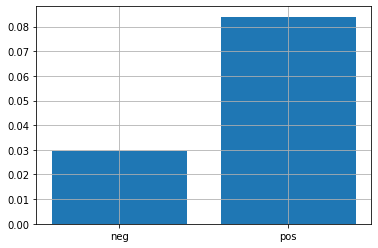

In [56]:
x = ['neg','pos']
bar(x, df[x].mean())
grid()

## Extracting tweets with a hashtag

In [57]:
htag = '#BlackLivesMatter'
tweets = []
for tw in tweepy.Cursor(api.search,q=htag).items(10):
    tweets.append(tw.text)
scores = []
for tw in tweets:
    print(tw)
    score = sid.polarity_scores(tw)
    scores.append(score)
    print(score)

RT @Alyssa_Milano: Warning: this is hard to watch. Watch it anyway. Don‚Äôt look away. #BlackLivesMatter https://t.co/Qa27El356s
{'neg': 0.213, 'neu': 0.787, 'pos': 0.0, 'compound': -0.4215}
RT @taynimated: ‚ÄºÔ∏è STOP SCROLLING FOR A SECOND ‚ÄºÔ∏è

There‚Äôs a bit of an update on the whole Pervis Payne situation.

Please read, spread thi‚Ä¶
{'neg': 0.112, 'neu': 0.801, 'pos': 0.088, 'compound': -0.1613}
RT @KatrinaPierson: Oops! ü§≠  

BLM Co-Founder Buys $1.4 Million Home In Virtually All-White Area.

Basically, #blacklivesmatter is a lucrat‚Ä¶
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
RT @Valeurs: üî¥ Une cofondatrice marxiste de #BlackLivesMatter s‚Äôach√®te une #villa √† 1,4 million de dollars dans un quartier blanc.
https://‚Ä¶
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
RT @AndyOstroy: In case anyone‚Äôs forgotten, this is why @Kaepernick7 took a knee... https://t.co/kYdnO7r5Rc #BlackLivesMatter
{'neg': 0.128, 'neu': 0.872, 'pos': 0.0, 'compound': -0.2263

In [58]:
df = pd.DataFrame(scores)
df

neg    neu    pos  compound
0  0.213  0.787  0.000   -0.4215
1  0.112  0.801  0.088   -0.1613
2  0.000  1.000  0.000    0.0000
3  0.000  1.000  0.000    0.0000
4  0.128  0.872  0.000   -0.2263
5  0.128  0.872  0.000   -0.2263
6  0.000  1.000  0.000    0.0000
7  0.000  0.885  0.115    0.4588
8  0.000  1.000  0.000    0.0000
9  0.000  1.000  0.000    0.0000

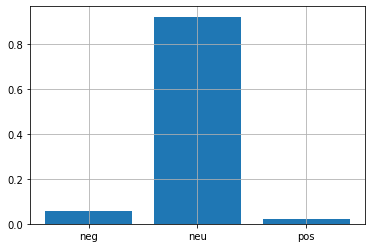

In [59]:
x = ['neg','neu','pos']
bar(x, df[x].mean())
grid()

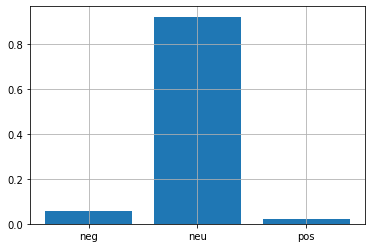

In [60]:
htag = '#Biden'
tweets = []
for tw in tweepy.Cursor(api.search,q=htag).items(10):
    tweets.append(tw.text)
scores = []
for tw in tweets:
#     print(tw)
    score = sid.polarity_scores(tw)
    scores.append(score)
#     print(score)

x = ['neg','neu','pos']
bar(x, df[x].mean())
grid()

## News Extractor: Reading in parts of a URL

Let's read in the top news from the ET main page. 

You also want to get SelectorGadget: http://selectorgadget.com/

In [61]:
!pip install cssselect

In [62]:
import requests
from lxml.html import fromstring

In [63]:
#Copy the URL from the web site
url = 'https://economictimes.indiatimes.com'
html = requests.get(url, timeout=10).text

#See: http://infohost.nmt.edu/~shipman/soft/pylxml/web/etree-fromstring.html
doc = fromstring(html)      

#http://lxml.de/cssselect.html#the-cssselect-method
doc.cssselect(".active")


[<Element li at 0x7f3361cb3650>,
 <Element li at 0x7f3361cb36b0>,
 <Element li at 0x7f3361cb3710>,
 <Element li at 0x7f3361cb3770>,
 <Element li at 0x7f3361cb37d0>,
 <Element li at 0x7f3361cb3830>,
 <Element li at 0x7f3361cb3890>,
 <Element li at 0x7f3361cb38f0>,
 <Element li at 0x7f3361cb3950>,
 <Element li at 0x7f3361cb39b0>]

In [64]:
x = doc.cssselect(".active li")    #Try a, h2, section if you like
headlines = [x[j].text_content() for j in range(len(x))]
headlines = headlines[:20]   #Needed to exclude any other stuff that was not needed. 
print(headlines)

['India considers reviving FTA talks with GCC', 'Covid is outpacing jabs. This needs to change', 'MCA moves NCLT against former mgmt of CG Power', 'Maha: 1st weekend lockdown comes into force ', 'Khaitan legal associate partners start new firm', 'India finalises air bubble pact with Sri Lanka', 'Mahindra to discontinue XUV500 next year', 'IIT researchers develop essential oil extractor', 'Petrol, diesel prices remain unchanged', 'SL currency faces heat after currency swap', 'Events leading up to $2.8 bn fine on Alibaba', 'IMF on how India can make faster recovery', 'India reports a record 1,45,384 Covid cases', 'Cloud With A Secure Lining', '$12.4b raised from pipeline stake sale: Aramco', 'Inside the fight for the future of WSJ', '', "US defends Navy operation inside India's EEZ", 'Vodafone Idea to clear Q4 dues by next week', "India in price talks for Sputnik V's import"]


In [65]:
#Sentiment scoring 
## Here we will read in an entire dictionary from Harvard Inquirer
f = open('NLP_data/inqdict.txt')
HIDict = f.read()
HIDict = HIDict.splitlines()
HIDict = HIDict[1:]
print(HIDict[:5])
print(len(HIDict))

#Extract all the lines that contain the Pos tag
poswords = [j for j in HIDict if "Pos" in j]  #using a list comprehension
poswords = [j.split()[0] for j in poswords]
poswords = [j.split("#")[0] for j in poswords]
poswords = unique(poswords)
poswords = [j.lower() for j in poswords]
print(poswords[:20])
print(len(poswords))

#Extract all the lines that contain the Neg tag
negwords = [j for j in HIDict if "Neg" in j]  #using a list comprehension
negwords = [j.split()[0] for j in negwords]
negwords = [j.split("#")[0] for j in negwords]
negwords = unique(negwords)
negwords = [j.lower() for j in negwords]
print(negwords[:20])
print(len(negwords))

['A H4Lvd DET ART  | article: Indefinite singular article--some or any one', 'ABANDON H4Lvd Neg Ngtv Weak Fail IAV AFFLOSS AFFTOT SUPV  |', 'ABANDONMENT H4 Neg Weak Fail Noun  |', 'ABATE H4Lvd Neg Psv Decr IAV TRANS SUPV  |', 'ABATEMENT Lvd Noun  ']
11895
['abide', 'able', 'abound', 'absolve', 'absorbent', 'absorption', 'abundance', 'abundant', 'accede', 'accentuate', 'accept', 'acceptable', 'acceptance', 'accessible', 'accession', 'acclaim', 'acclamation', 'accolade', 'accommodate', 'accommodation']
1646
['abandon', 'abandonment', 'abate', 'abdicate', 'abhor', 'abject', 'abnormal', 'abolish', 'abominable', 'abrasive', 'abrupt', 'abscond', 'absence', 'absent', 'absent-minded', 'absentee', 'absurd', 'absurdity', 'abuse', 'abyss']
2120


In [66]:
#Create a sentiment scoring function
def textSentiment(text,poswords,negwords):   
    text.lower(); print(text)
    text = text.split(' ')
    posmatches = set(text).intersection(set(poswords)); print(posmatches)
    negmatches = set(text).intersection(set(negwords)); print(negmatches)
    return [len(posmatches),len(negmatches)]

In [67]:
for h in headlines:
    s = textSentiment(h,poswords,negwords)
    print(s)

India considers reviving FTA talks with GCC
set()
set()
[0, 0]
Covid is outpacing jabs. This needs to change
set()
set()
[0, 0]
MCA moves NCLT against former mgmt of CG Power
set()
{'against'}
[0, 1]
Maha: 1st weekend lockdown comes into force 
set()
{'force'}
[0, 1]
Khaitan legal associate partners start new firm
{'associate', 'legal'}
set()
[2, 0]
India finalises air bubble pact with Sri Lanka
set()
set()
[0, 0]
Mahindra to discontinue XUV500 next year
set()
{'discontinue'}
[0, 1]
IIT researchers develop essential oil extractor
{'essential'}
set()
[1, 0]
Petrol, diesel prices remain unchanged
set()
{'unchanged'}
[0, 1]
SL currency faces heat after currency swap
set()
set()
[0, 0]
Events leading up to $2.8 bn fine on Alibaba
{'fine'}
{'fine'}
[1, 1]
IMF on how India can make faster recovery
{'make'}
{'make'}
[1, 1]
India reports a record 1,45,384 Covid cases
set()
set()
[0, 0]
Cloud With A Secure Lining
set()
set()
[0, 0]
$12.4b raised from pipeline stake sale: Aramco
set()
set()
[0, 

## Using R for extraction with rvest

Run this in a new notebook with the R kernel. 

In [ ]:
# !pip install rpy2   # run this in the R kernel with: system('pip install rpy2')
# %load_ext rpy2.ipython

In [68]:
%%R
install.packages(c("rvest","magrittr","stringr"))

R[write to console]: Installing packages into ‚Äò/usr/local/lib/R/site-library‚Äô
(as ‚Äòlib‚Äô is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/rvest_1.0.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 94134 bytes (91 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R

In [69]:
%%R
library(rvest)
library(magrittr)
library(stringr)

In [70]:
%%R
ticker = "AMZN"
url = paste("https://finance.yahoo.com/quote/",ticker,"/profile?p=",ticker,sep="")
print(url)
doc = read_html(url)
res = doc %>% html_nodes("table") %>% html_table()
print(res)
print(res[[1]]$Name[1])

[1] "https://finance.yahoo.com/quote/AMZN/profile?p=AMZN"
[[1]]
# A tibble: 10 x 5
   Name            Title                            Pay    Exercised `Year Born`
   <chr>           <chr>                            <chr>  <chr>     <chr>      
 1 Mr. Jeffrey P.‚Ä¶ Founder, Chairman, Pres & CEO    1.68M  N/A       1964       
 2 Mr. Brian T. O‚Ä¶ Sr. VP & CFO                     163.2k N/A       1964       
 3 Mr. Andrew R. ‚Ä¶ Chief Exec. Officer of Amazon W‚Ä¶ 348.8‚Ä¶ N/A       1968       
 4 Ms. Shelley L.‚Ä¶ VP, Worldwide Controller & Prin‚Ä¶ N/A    N/A       1965       
 5 Dr. Werner  Vo‚Ä¶ Chief Technology Officer         N/A    N/A       N/A        
 6 Mr. Dave  Fild‚Ä¶ Director of Investor Relations   N/A    N/A       N/A        
 7 Mr. David A. Z‚Ä¶ Sr. VP, Gen. Counsel & Sec.      N/A    N/A       1964       
 8 Ms. Ragia  Sam‚Ä¶ Head of Marketing                N/A    N/A       N/A        
 9 Ms. Beth  Gale‚Ä¶ Sr. VP of Worldwide HR           N/A    N/A       N/A        
10

In [71]:
%%R
res = doc %>% html_nodes("p") %>% html_text()
print(res)

[1] "410 Terry Avenue NorthSeattle, WA 98109-5210United States206-266-1000http://www.amazon.com"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

## Using Amazon Textract

- Documentation: https://textract.readthedocs.io/en/stable/python_package.html

- Code samples: https://github.com/aws-samples/amazon-textract-code-samples

- In case you need to install tesseract: https://textract.readthedocs.io/en/latest/installation.html

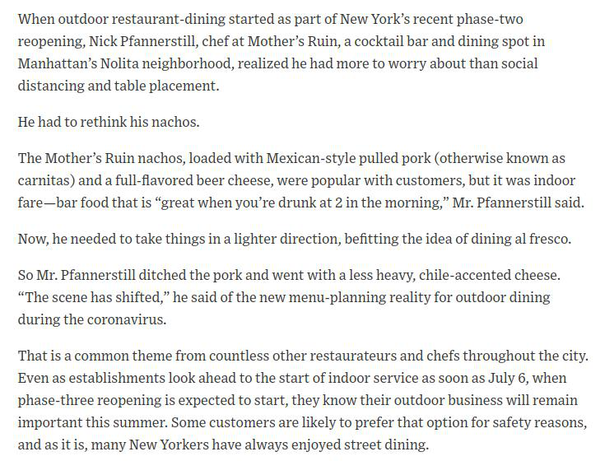

In [72]:
nb_setup.images_hconcat(["NLP_images/wsj_text.jpeg"], width=600)

In [ ]:
# See instructions here: https://textract.readthedocs.io/en/latest/installation.html

# !sudo apt-get install python-dev libxml2-dev libxslt1-dev antiword unrtf poppler-utils pstotext tesseract-ocr flac ffmpeg lame libmad0 libsox-fmt-mp3 sox libjpeg-dev swig libpulse-dev
# !pip install pytesseract
# !pip install textract

# from bs4 import BeautifulSoup
# clean_text = BeautifulSoup(text,'lxml').get_text()
# print(clean_text)

## AWS Textract Steps

1. Create a S3 bucket, use all lower case.
2. Upload a JPEG file.
3. Call it from Textract using a simple command line interface.

```
[default]
aws_access_key_id = AKIAYNQOKXOFYHNEWHSWJ
aws_secret_access_key = dSwPa0krngewWudGcyUgZ219XVZ0IzpMe3LO3ojzP56
```

In [ ]:
text = !aws textract analyze-document --document '{"S3Object":{"Bucket":"nlp-course-sanjivda","Name":"wsj_text.jpeg"}}' --feature-types '["TABLES","FORMS"]'

text

['{',
 '    "DocumentMetadata": {',
 '        "Pages": 1',
 '    },',
 '    "Blocks": [',
 '        {',
 '            "BlockType": "PAGE",',
 '            "Geometry": {',
 '                "BoundingBox": {',
 '                    "Width": 1.0,',
 '                    "Height": 1.0,',
 '                    "Left": 0.0,',
 '                    "Top": 0.0',
 '                },',
 '                "Polygon": [',
 '                    {',
 '                        "X": 0.0,',
 '                        "Y": 0.0',
 '                    },',
 '                    {',
 '                        "X": 1.0,',
 '                        "Y": 0.0',
 '                    },',
 '                    {',
 '                        "X": 1.0,',
 '                        "Y": 1.0',
 '                    },',
 '                    {',
 '                        "X": 0.0,',
 '                        "Y": 1.0',
 '                    }',
 '                ]',
 '            },',
 '            "Id": "6839f0a6-dc47-

In [ ]:
f = text.fields()
f

[['{'],
 ['"DocumentMetadata":', '{'],
 ['"Pages":', '1'],
 ['},'],
 ['"Blocks":', '['],
 ['{'],
 ['"BlockType":', '"PAGE",'],
 ['"Geometry":', '{'],
 ['"BoundingBox":', '{'],
 ['"Width":', '1.0,'],
 ['"Height":', '1.0,'],
 ['"Left":', '0.0,'],
 ['"Top":', '0.0'],
 ['},'],
 ['"Polygon":', '['],
 ['{'],
 ['"X":', '0.0,'],
 ['"Y":', '0.0'],
 ['},'],
 ['{'],
 ['"X":', '1.0,'],
 ['"Y":', '0.0'],
 ['},'],
 ['{'],
 ['"X":', '1.0,'],
 ['"Y":', '1.0'],
 ['},'],
 ['{'],
 ['"X":', '0.0,'],
 ['"Y":', '1.0'],
 ['}'],
 [']'],
 ['},'],
 ['"Id":', '"6839f0a6-dc47-433e-9b58-cfbb2717e496",'],
 ['"Relationships":', '['],
 ['{'],
 ['"Type":', '"CHILD",'],
 ['"Ids":', '['],
 ['"08f28d29-7835-454f-95d3-6b7359c23b34",'],
 ['"5e0b8e1d-cb4d-4113-b544-e9abd565bbf3",'],
 ['"1e9c4155-cb33-4159-9067-acfcae4a52f6",'],
 ['"f2939304-2308-4c06-ab08-86043945348d",'],
 ['"16402ad0-547e-4497-baeb-1c66a79eca87",'],
 ['"c948d55f-e47c-4ed3-958c-6b08eaaaf2bb",'],
 ['"66f0f906-e9a1-43b8-86a8-652251de4ac1",'],
 ['"ec19fafb-b3

In [ ]:
res = [j[1:] for j in f if j[0]=='"Text":']
print(res)

[['"When', 'outdoor', 'restaurant-dining', 'started', 'as', 'part', 'of', 'New', "York's", 'recent', 'phase-two",'], ['"reopening,', 'Nick', 'Pfannerstill,', 'chef', 'at', "Mother's", 'Ruin,', 'a', 'cocktail', 'bar', 'and', 'dining', 'spot', 'in",'], ['"Manhattan\'s', 'Nolita', 'neighborhood,', 'realized', 'he', 'had', 'more', 'to', 'worry', 'about', 'than', 'social",'], ['"distancing', 'and', 'table', 'placement.",'], ['"He', 'had', 'to', 'rethink', 'his', 'nachos.",'], ['"The', "Mother's", 'Ruin', 'nachos,', 'loaded', 'with', 'Mexican-style', 'pulled', 'pork', '(otherwise', 'known",'], ['"as",'], ['"carnitas)', 'and', 'a', 'full-flavored', 'beer', 'cheese,', 'were', 'popular', 'with', 'customers,', 'but', 'it', 'was', 'indoor",'], ['"fare-bar', 'food', 'that', 'is', '\\"great', 'when', "you're", 'drunk', 'at', '2', 'in', 'the', "morning,'", 'Mr.', 'Pfannerstill', 'said.",'], ['"Now,', 'he', 'needed', 'to', 'take', 'things', 'in', 'a', 'lighter', 'direction,', 'befitting', 'the', 'ide

In [ ]:
res2 = [" ".join(j) for j in res]
res2 = " ".join(res2)
print(res2)
print('------------')
res2 = re.sub('", "',' ',res2)
print(res2)

"When outdoor restaurant-dining started as part of New York's recent phase-two", "reopening, Nick Pfannerstill, chef at Mother's Ruin, a cocktail bar and dining spot in", "Manhattan's Nolita neighborhood, realized he had more to worry about than social", "distancing and table placement.", "He had to rethink his nachos.", "The Mother's Ruin nachos, loaded with Mexican-style pulled pork (otherwise known", "as", "carnitas) and a full-flavored beer cheese, were popular with customers, but it was indoor", "fare-bar food that is \"great when you're drunk at 2 in the morning,' Mr. Pfannerstill said.", "Now, he needed to take things in a lighter direction, befitting the idea of dining al fresco.", "So Mr. Pfannerstill ditched the pork and went with a less heavy, chile-accented cheese.", "\"The scene has shifted,\" he said of the new menu-planning reality for outdoor dining", "during the coronavirus.", "That is a common theme from countless other restaurateurs and chefs throughout the city.", "